# 05 - Deep Learning Models: CICIDS2017 Dataset

This notebook implements and evaluates deep learning models for intrusion detection.

## Objectives:
1. Load engineered features
2. Build and train deep learning architectures
3. Implement MLP, CNN, LSTM, and Autoencoder models
4. Evaluate and compare model performances
5. Save best models for deployment

## 1. Setup and Imports

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import json
import joblib
import os
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("✓ Libraries imported successfully")

TensorFlow version: 2.20.0
GPU available: []
✓ Libraries imported successfully


## 2. Load Engineered Data

In [2]:
print("\n=== Loading Engineered Features ===")

processed_path = '../data/processed'

X_train = np.load(os.path.join(processed_path, 'X_train_engineered.npy'))
X_val = np.load(os.path.join(processed_path, 'X_val_engineered.npy'))
X_test = np.load(os.path.join(processed_path, 'X_test_engineered.npy'))

y_train = np.load(os.path.join(processed_path, 'y_train.npy'))
y_val = np.load(os.path.join(processed_path, 'y_val.npy'))
y_test = np.load(os.path.join(processed_path, 'y_test.npy'))

with open(os.path.join(processed_path, 'feature_engineering_info.json'), 'r') as f:
    feature_info = json.load(f)

print(f"\n✓ Data loaded successfully")
print(f"  Training samples: {X_train.shape}")
print(f"  Validation samples: {X_val.shape}")
print(f"  Test samples: {X_test.shape}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Number of classes: {len(np.unique(y_train))}")


=== Loading Engineered Features ===

✓ Data loaded successfully
  Training samples: (2935076, 30)
  Validation samples: (252237, 30)
  Test samples: (504473, 30)
  Number of features: 30
  Number of classes: 2



=== Class Distribution ===
   Class    Count  Percentage
0      0  1467538        50.0
1      1  1467538        50.0


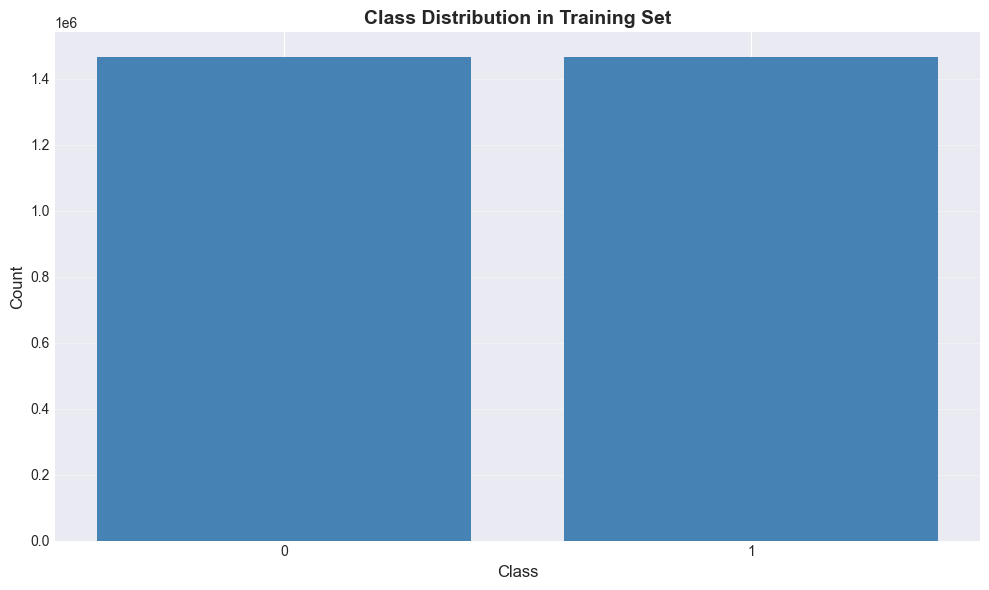

In [3]:
print("\n=== Class Distribution ===")

unique, counts = np.unique(y_train, return_counts=True)
class_dist = pd.DataFrame({'Class': unique, 'Count': counts, 'Percentage': counts/len(y_train)*100})
print(class_dist)

n_classes = len(unique)
input_dim = X_train.shape[1]

plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='steelblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Prepare Data for Deep Learning

In [4]:
print("\n=== Preparing Data for Deep Learning ===")

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

y_train_cat = to_categorical(y_train_encoded, num_classes=n_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes=n_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=n_classes)

print(f"\n✓ Labels encoded")
print(f"  Original labels shape: {y_train.shape}")
print(f"  Categorical labels shape: {y_train_cat.shape}")
print(f"  Number of classes: {n_classes}")

joblib.dump(le, os.path.join(processed_path, 'label_encoder.pkl'))
print("✓ Label encoder saved")


=== Preparing Data for Deep Learning ===

✓ Labels encoded
  Original labels shape: (2935076,)
  Categorical labels shape: (2935076, 2)
  Number of classes: 2
✓ Label encoder saved


## 4. Define Callbacks and Utilities

In [6]:
models_path = '../data/models'
os.makedirs(models_path, exist_ok=True)

def get_callbacks(model_name):
    """Create callbacks for model training"""
    
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    checkpoint = callbacks.ModelCheckpoint(
        filepath=os.path.join(models_path, f'{model_name}_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    return [early_stop, reduce_lr, checkpoint]

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Callbacks and utilities defined")

✓ Callbacks and utilities defined


## 5. Model 1: Multi-Layer Perceptron (MLP)

In [11]:
print("\n" + "="*70)
print("MODEL 1: MULTI-LAYER PERCEPTRON (MLP)")
print("="*70)

def build_mlp(input_dim, n_classes):
    """Build Multi-Layer Perceptron model with improved regularization"""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

mlp_model = build_mlp(input_dim, n_classes)
mlp_model.summary()


MODEL 1: MULTI-LAYER PERCEPTRON (MLP)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,266 (59.63 KB)

 Trainable params: 14,818 (57.88 KB)

 Non-trainable params: 448 (1.75 KB)


Training MLP Model...
----------------------------------------------------------------------
Epoch 1/50
11453/11466 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8839 - loss: 0.9857
Epoch 1: val_accuracy improved from None to 0.95888, saving model to ../data/models\mlp_best.keras

Epoch 1: finished saving model to ../data/models\mlp_best.keras
11466/11466 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9339 - loss: 0.4683 - val_accuracy: 0.9589 - val_loss: 0.1052 - learning_rate: 1.0000e-04
Epoch 2/50
11449/11466 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9685 - loss: 0.1028
Epoch 2: val_accuracy improved from 0.95888 to 0.97115, saving model to ../data/models\mlp_best.keras

Epoch 2: finished saving model to ../data/models\mlp_best.keras
11466/11466 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9702 - loss: 0.0964 - val_accuracy: 0.9712 - val_loss: 0.0760 - learning_rate: 1.0000e-04
Epoch 3/50
11460/11466 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.0851
Epoch

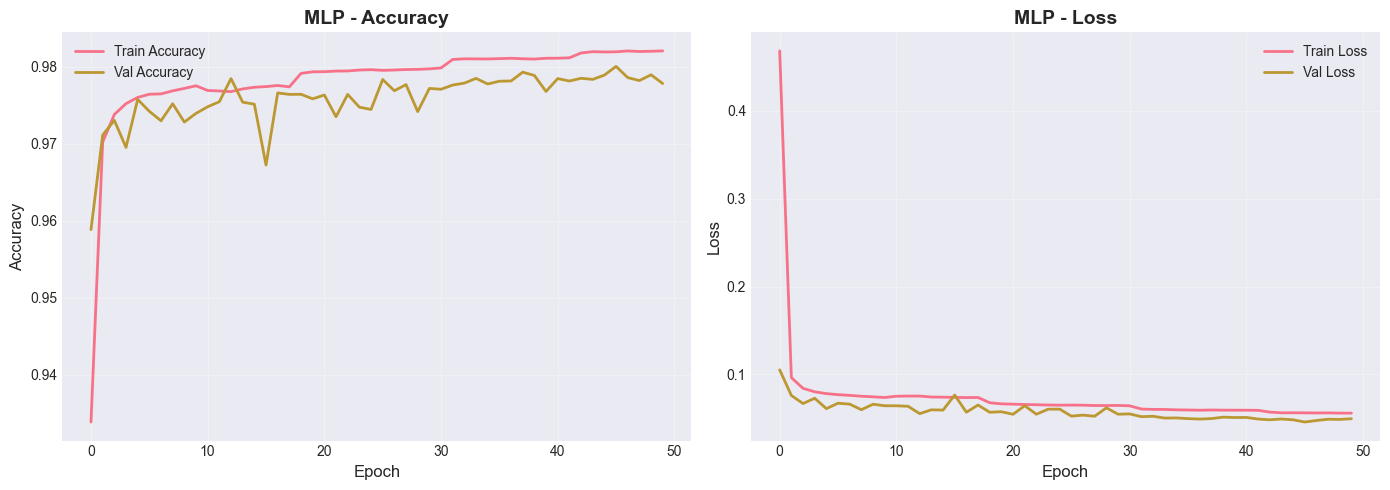

In [12]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,                    # Stop if no improvement for 10 epochs
    restore_best_weights=True,      # Use the best model, not the last one
    verbose=1
)

print("\nTraining MLP Model...")
print("-" * 70)

mlp_history = mlp_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,                      # Reduced from 100
    batch_size=256,
    callbacks=[early_stopping] + get_callbacks('mlp'),  # Add early stopping
    verbose=1
)

print(f"\n✓ MLP training completed (stopped at epoch {len(mlp_history.history['loss'])})")
plot_training_history(mlp_history, 'MLP')

## 6. Model 2: 1D Convolutional Neural Network (CNN)


MODEL 2: 1D CONVOLUTIONAL NEURAL NETWORK (CNN)

Reshaped data for CNN:
  Training: (2935076, 30, 1)
  Validation: (252237, 30, 1)
  Test: (504473, 30, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 7, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,266 (59.63 KB)

 Trainable params: 15,010 (58.63 KB)

 Non-trainable params: 256 (1.00 KB)


Training CNN Model...
----------------------------------------------------------------------
Epoch 1/30
11465/11466 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8971 - loss: 0.5126
Epoch 1: val_accuracy improved from None to 0.94821, saving model to ../data/models\cnn_best.keras

Epoch 1: finished saving model to ../data/models\cnn_best.keras
11466/11466 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.9368 - loss: 0.2557 - val_accuracy: 0.9482 - val_loss: 0.1247 - learning_rate: 5.0000e-04
Epoch 2/30
11459/11466 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9534 - loss: 0.1513
Epoch 2: val_accuracy did not improve from 0.94821
11466/11466 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9537 - loss: 0.1504 - val_accuracy: 0.9466 - val_loss: 0.1248 - learning_rate: 5.0000e-04
Epoch 3/30
11464/11466 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9540 - loss: 0.1488
Epoch 3: val_accuracy improved from 0.94821 to 0.95016, saving model to ../data/models\cnn_best.keras

Epoch 3: finished 

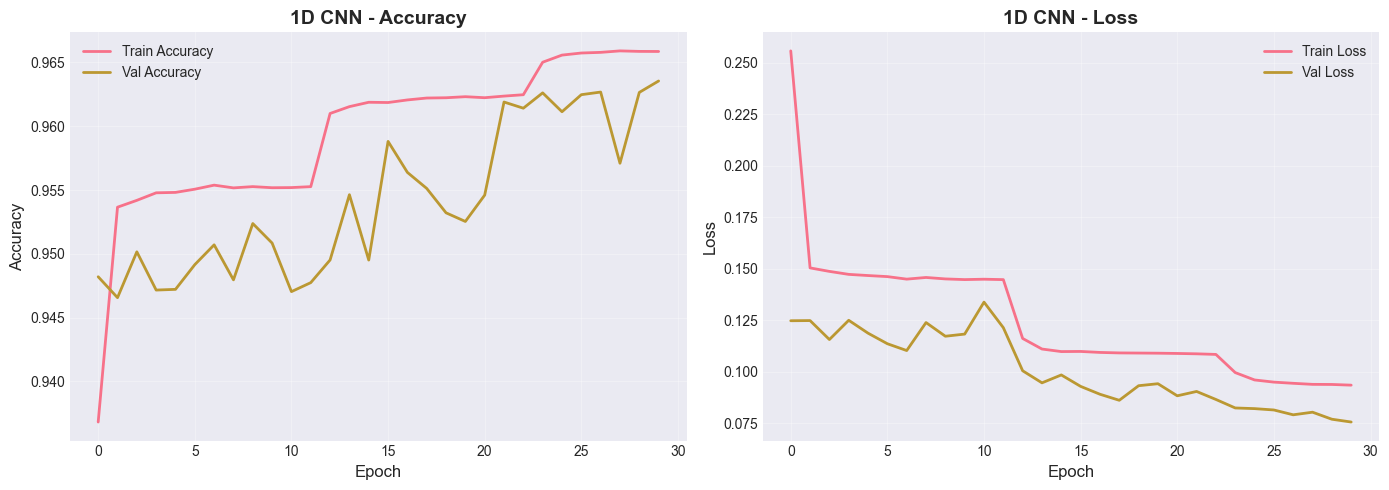

In [14]:
print("\n" + "="*70)
print("MODEL 2: 1D CONVOLUTIONAL NEURAL NETWORK (CNN)")
print("="*70)

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nReshaped data for CNN:")
print(f"  Training: {X_train_cnn.shape}")
print(f"  Validation: {X_val_cnn.shape}")
print(f"  Test: {X_test_cnn.shape}")

def build_cnn(input_dim, n_classes):
    """Build 1D Convolutional Neural Network with improved regularization"""
    model = models.Sequential([
        layers.Input(shape=(input_dim, 1)),
        
        # First Conv Block - Reduced filters from 64 to 32
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),  # Increased from 0.3
        
        # Second Conv Block - Reduced filters from 128 to 64
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.4),  # Increased from 0.3
        
        # Third Conv Block - Reduced filters from 64 to 32
        layers.Conv1D(32, kernel_size=3, activation='relu', padding='same',
                     kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.GlobalMaxPooling1D(),
        layers.Dropout(0.4),  # Added dropout after pooling
        
        # Dense Layers - Reduced from 128 to 64
        layers.Dense(64, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),  # Increased from 0.3
        
        # Removed one dense layer for simplicity
        
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduced from 0.001
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Early stopping callback
early_stopping_cnn = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction callback
reduce_lr_cnn = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

cnn_model = build_cnn(input_dim, n_classes)
cnn_model.summary()

print("\nTraining CNN Model...")
print("-" * 70)

cnn_history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=30,  
    batch_size=256,
    callbacks=[early_stopping_cnn, reduce_lr_cnn] + get_callbacks('cnn'),
    verbose=1
)

print(f"\n✓ CNN training completed (stopped at epoch {len(cnn_history.history['loss'])})")
plot_training_history(cnn_history, '1D CNN')

NameError: name 'model' is not defined

## 9. Model Evaluation Functions

In [26]:
def evaluate_model(model, X_test, y_test_cat, y_test_orig, model_name, is_cnn=False):
    """Comprehensive model evaluation"""
    print(f"\n{'='*70}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*70}")
    
    # Prepare input based on model type
    if is_cnn:
        X_test_input = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    else:
        X_test_input = X_test
    
    # Make predictions
    print("\nMaking predictions...")
    y_pred_proba = model.predict(X_test_input, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    
    # Get number of classes
    n_classes = y_test_cat.shape[1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    # Print overall metrics
    print(f"\n{model_name} Performance Metrics:")
    print(f"  {'Accuracy:':<15} {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  {'Precision:':<15} {precision:.4f}")
    print(f"  {'Recall:':<15} {recall:.4f}")
    print(f"  {'F1-Score:':<15} {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot 1: Confusion Matrices
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=True)
    axes[0].set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1], cbar=True)
    axes[1].set_title(f'{model_name} - Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=[f'Class {i}' for i in range(n_classes)],
                                zero_division=0))
    
    # Calculate per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    # Plot 2: Per-class Metrics
    classes = [f'Class {i}' for i in range(n_classes)]
    x_pos = np.arange(len(classes))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].bar(x_pos, precision_per_class, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Class', fontsize=11)
    axes[0].set_ylabel('Precision', fontsize=11)
    axes[0].set_title('Precision per Class', fontsize=12, fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0].set_ylim([0, 1.05])
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(precision_per_class):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    axes[1].bar(x_pos, recall_per_class, color='darkorange', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Class', fontsize=11)
    axes[1].set_ylabel('Recall', fontsize=11)
    axes[1].set_title('Recall per Class', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(classes, rotation=45, ha='right')
    axes[1].set_ylim([0, 1.05])
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(recall_per_class):
        axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    axes[2].bar(x_pos, f1_per_class, color='seagreen', alpha=0.7, edgecolor='black')
    axes[2].set_xlabel('Class', fontsize=11)
    axes[2].set_ylabel('F1-Score', fontsize=11)
    axes[2].set_title('F1-Score per Class', fontsize=12, fontweight='bold')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(classes, rotation=45, ha='right')
    axes[2].set_ylim([0, 1.05])
    axes[2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(f1_per_class):
        axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Confidence Analysis
    confidence_scores = np.max(y_pred_proba, axis=1)
    correct_predictions = (y_pred == y_true)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    axes[0].hist(confidence_scores[correct_predictions], bins=30, alpha=0.7, 
                 label=f'Correct ({np.sum(correct_predictions)})', color='green', edgecolor='black')
    axes[0].hist(confidence_scores[~correct_predictions], bins=30, alpha=0.7, 
                 label=f'Incorrect ({np.sum(~correct_predictions)})', color='red', edgecolor='black')
    axes[0].set_xlabel('Prediction Confidence', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)
    
    avg_confidence_per_class = []
    for class_idx in range(n_classes):
        class_mask = (y_true == class_idx)
        if np.sum(class_mask) > 0:
            avg_confidence_per_class.append(np.mean(confidence_scores[class_mask]))
        else:
            avg_confidence_per_class.append(0)
    
    axes[1].bar(x_pos, avg_confidence_per_class, color='purple', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Class', fontsize=11)
    axes[1].set_ylabel('Average Confidence', fontsize=11)
    axes[1].set_title('Average Prediction Confidence per Class', fontsize=12, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(classes, rotation=45, ha='right')
    axes[1].set_ylim([0, 1.05])
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(avg_confidence_per_class):
        axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\nAdditional Statistics:")
    print(f"  {'Total Samples:':<30} {len(y_true)}")
    print(f"  {'Correct Predictions:':<30} {np.sum(correct_predictions)} ({np.sum(correct_predictions)/len(y_true)*100:.2f}%)")
    print(f"  {'Incorrect Predictions:':<30} {np.sum(~correct_predictions)} ({np.sum(~correct_predictions)/len(y_true)*100:.2f}%)")
    print(f"  {'Average Confidence (All):':<30} {np.mean(confidence_scores):.4f}")
    print(f"  {'Average Confidence (Correct):':<30} {np.mean(confidence_scores[correct_predictions]):.4f}")
    if np.sum(~correct_predictions) > 0:
        print(f"  {'Average Confidence (Incorrect):':<30} {np.mean(confidence_scores[~correct_predictions]):.4f}")
    
    # Return results dictionary
    return {
        'model_name': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist(),
        'precision_per_class': precision_per_class.tolist(),
        'recall_per_class': recall_per_class.tolist(),
        'f1_per_class': f1_per_class.tolist(),
        'support_per_class': support.tolist(),
        'avg_confidence': float(np.mean(confidence_scores)),
        'avg_confidence_correct': float(np.mean(confidence_scores[correct_predictions])),
        'avg_confidence_incorrect': float(np.mean(confidence_scores[~correct_predictions])) if np.sum(~correct_predictions) > 0 else 0.0
    }

In [30]:
from tensorflow.keras.models import load_model

model = load_model("../data/models/mlp_best.keras")



EVALUATING: My Model

Making predictions...

My Model Performance Metrics:
  Accuracy:       0.9796 (97.96%)
  Precision:      0.9815
  Recall:         0.9796
  F1-Score:       0.9800


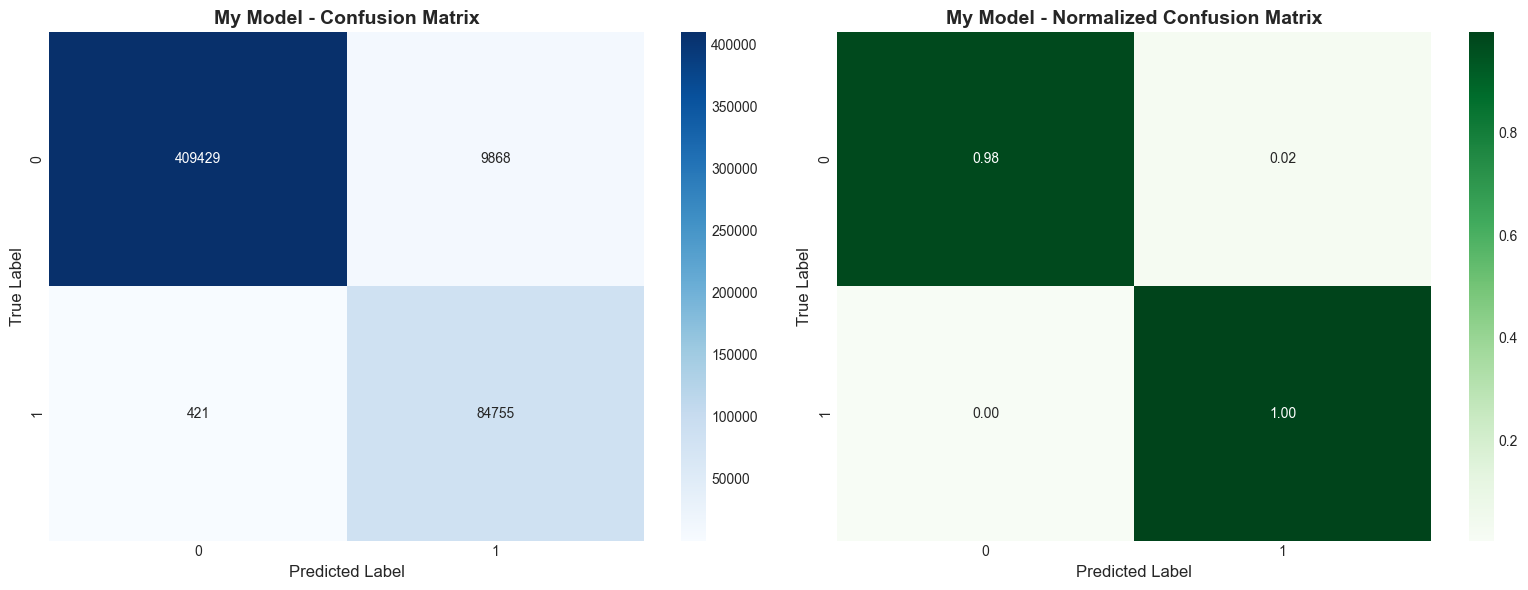


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.98      0.99    419297
     Class 1       0.90      1.00      0.94     85176

    accuracy                           0.98    504473
   macro avg       0.95      0.99      0.97    504473
weighted avg       0.98      0.98      0.98    504473



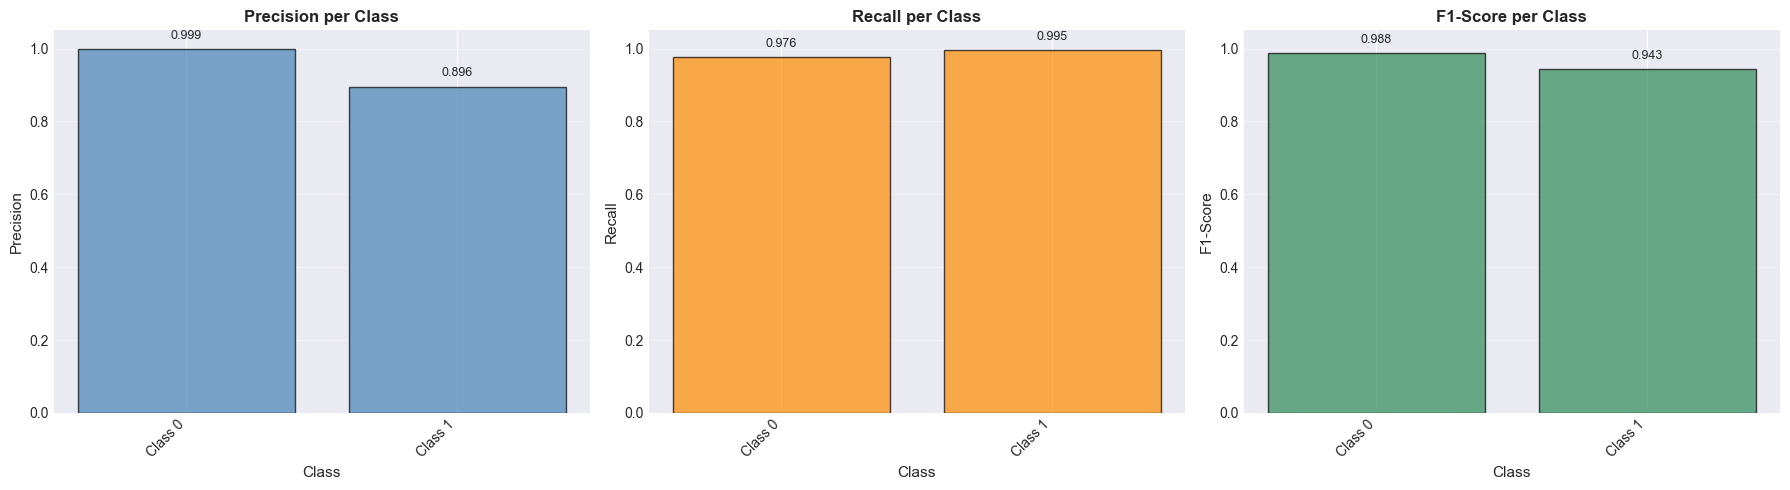

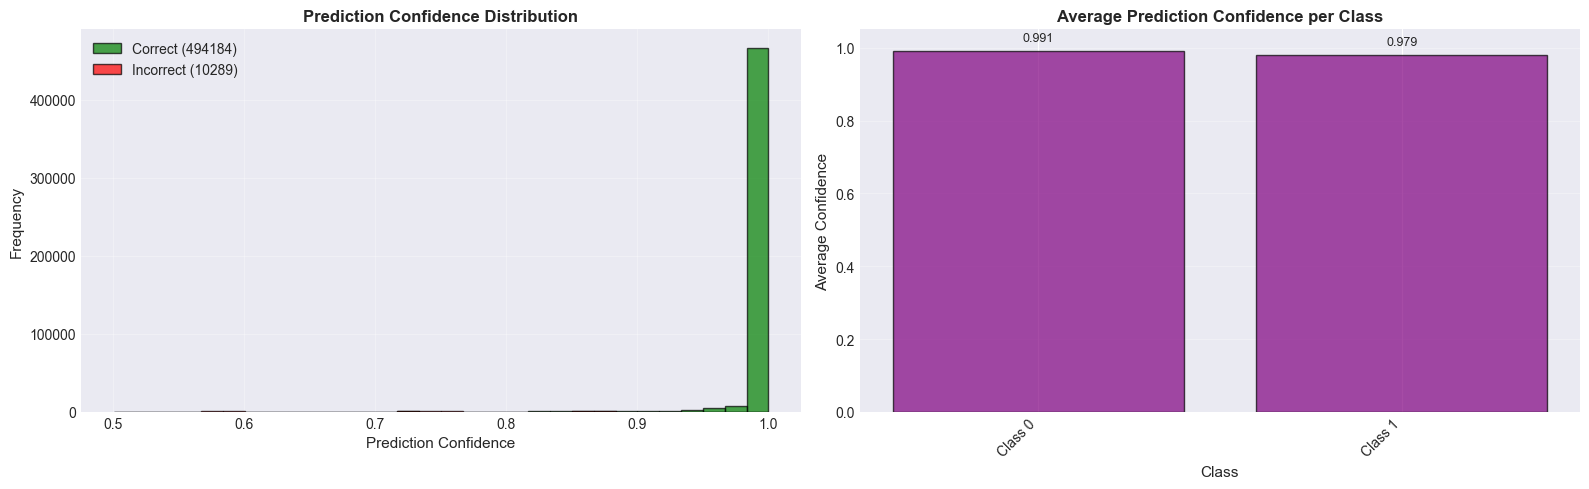


Additional Statistics:
  Total Samples:                 504473
  Correct Predictions:           494184 (97.96%)
  Incorrect Predictions:         10289 (2.04%)
  Average Confidence (All):      0.9891
  Average Confidence (Correct):  0.9937
  Average Confidence (Incorrect): 0.7665


In [32]:
results = evaluate_model(model, X_test, y_test_cat, y_test, "My Model", is_cnn=False)



EVALUATING: My Model

Making predictions...

My Model Performance Metrics:
  Accuracy:       0.9631 (96.31%)
  Precision:      0.9687
  Recall:         0.9631
  F1-Score:       0.9644


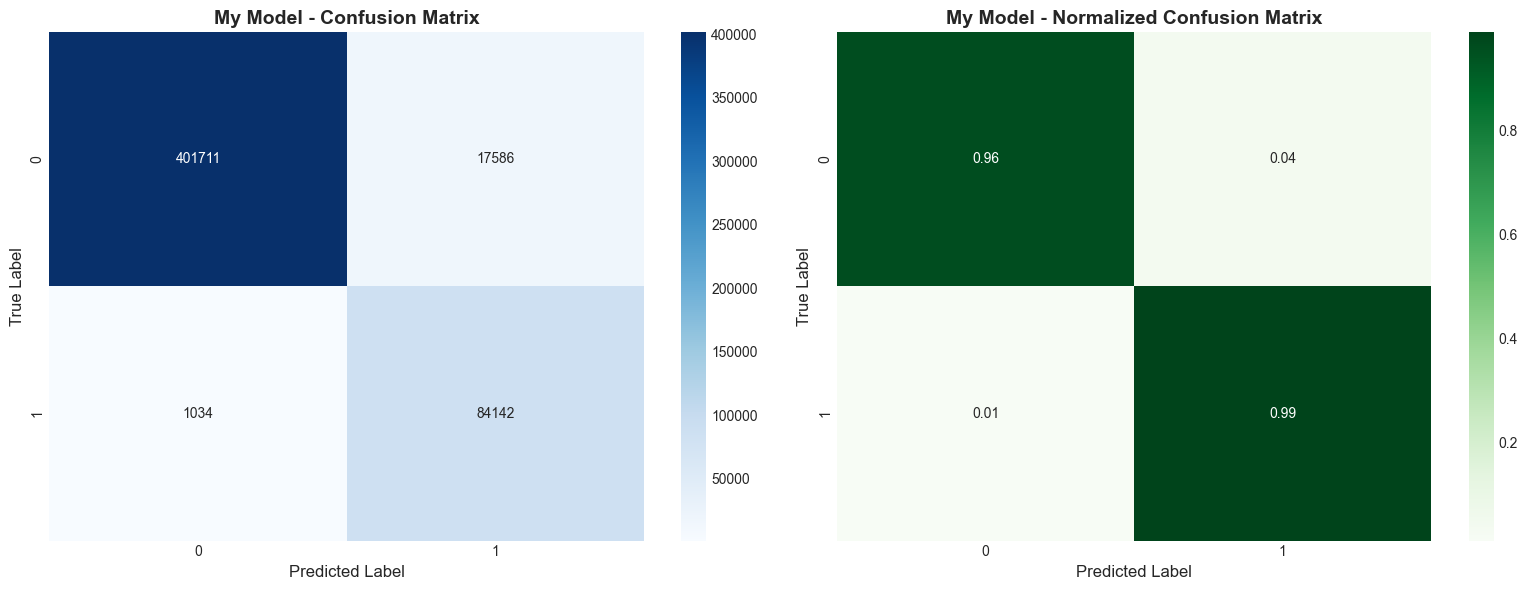


Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98    419297
     Class 1       0.83      0.99      0.90     85176

    accuracy                           0.96    504473
   macro avg       0.91      0.97      0.94    504473
weighted avg       0.97      0.96      0.96    504473



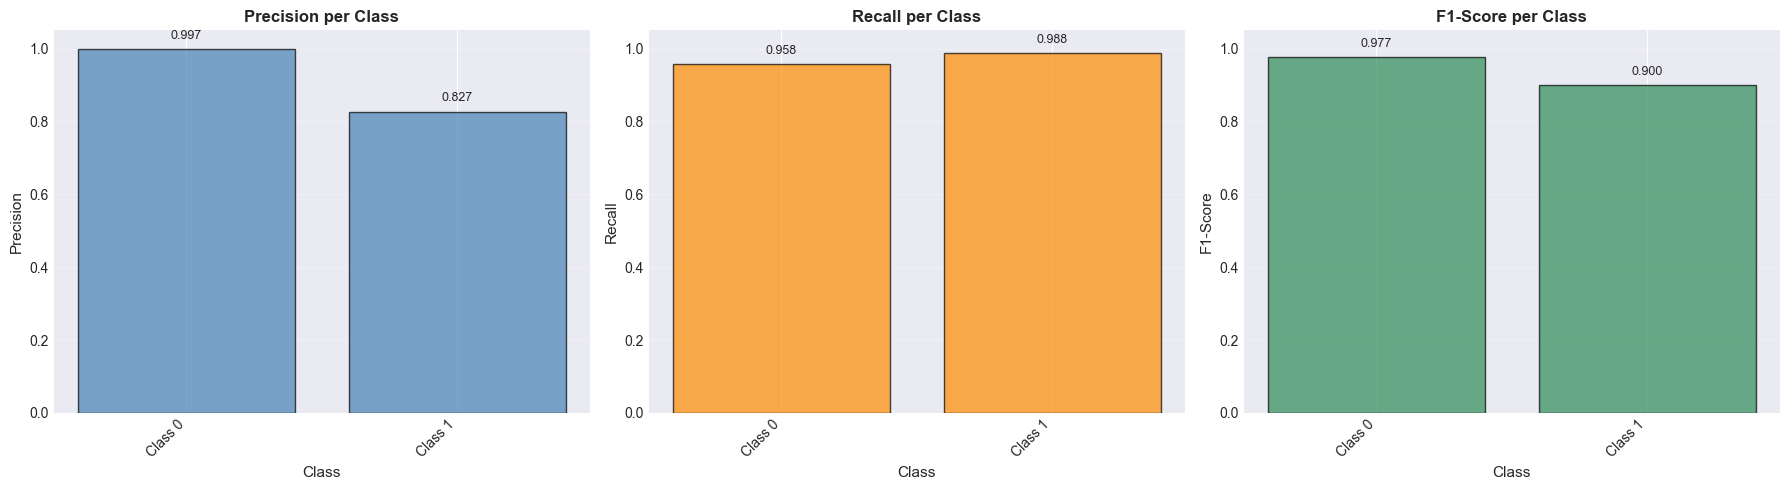

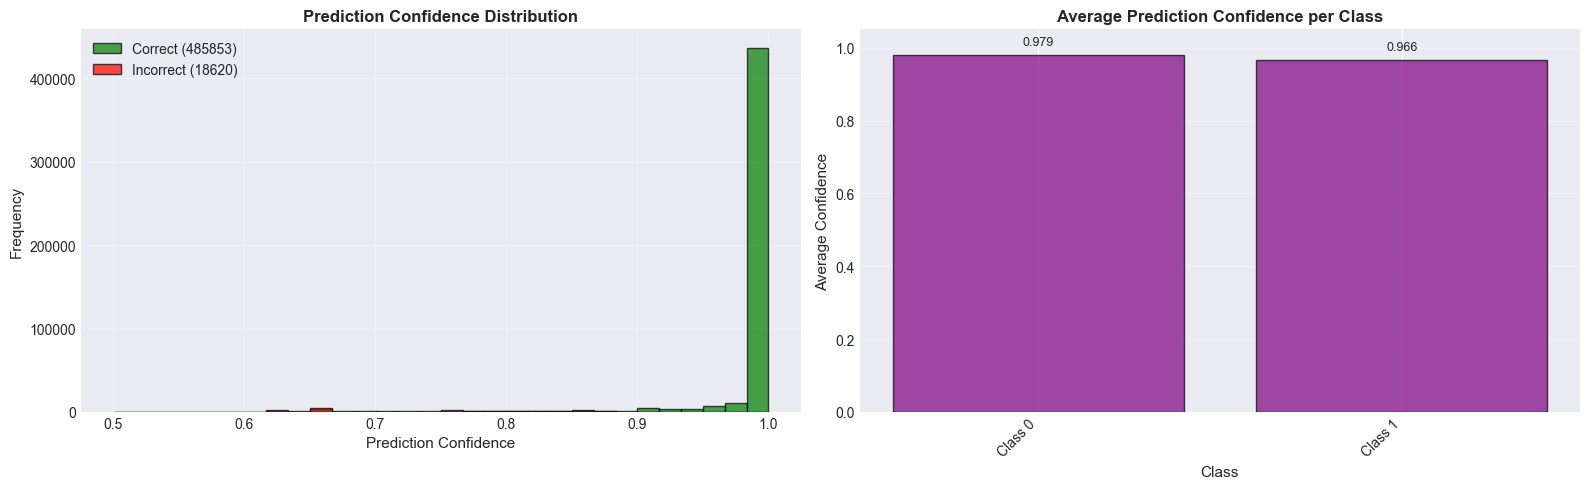


Additional Statistics:
  Total Samples:                 504473
  Correct Predictions:           485853 (96.31%)
  Incorrect Predictions:         18620 (3.69%)
  Average Confidence (All):      0.9771
  Average Confidence (Correct):  0.9863
  Average Confidence (Incorrect): 0.7367


In [33]:
from tensorflow.keras.models import load_model

model = load_model("../data/models/cnn_best.keras")
results = evaluate_model(model, X_test, y_test_cat, y_test, "My Model", is_cnn=False)

